>## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import PIL.Image
import cv2, os, glob
from skimage.transform import pyramid_expand
from skimage.transform import pyramid_reduce 

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('dark_background')    

import warnings
warnings.filterwarnings(action='ignore')

def fn_makedirs(path): 
   try: 
        os.makedirs(path) 
   except OSError: 
       if not os.path.isdir(path): 
           raise

>## 데이터 전처리(preprocessing)

1) 데이터는 네트워크에 주입되기 전에 부동 소수점 타입의 텐서로 적절하게 전처리

2) 사진 피일을 읽는다.

3) JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.

4) 그 다음, 부동 소수점 타입의 텐서로 변환

5) 동일한 크기의 이미지로 변경

6) 배치로 묶는다.

- Download / load the training dataset

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

print(data_dir)

228813984/228813984 [==============================] - 6s 0us/step
/root/.keras/datasets/flower_photos


- directory 구조

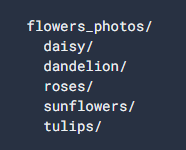

- data의 갯수 확인

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


- 데이터 출력

[PosixPath('/root/.keras/datasets/flower_photos/roses/16018886851_c32746cb72.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/5172171681_5934378f08.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/229488796_21ac6ee16d_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/12165480946_c4a3fe182d_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/7304710956_015b41f802_m.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2471103806_87ba53d997_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/3624546109_8eb98f0cdb.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2735666555_01d53e74fe.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2409069862_b128ee2a71.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/3872230296_6c477309f3_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2536282942_b5ca27577e.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/8667746487_781af9e615_n.jpg'), Po

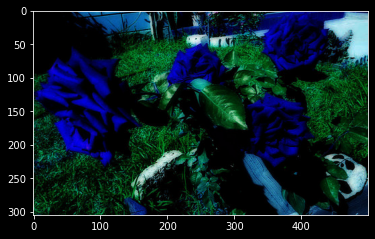

In [5]:
roses = list(data_dir.glob('roses/*'))
print(roses)
roses_cnt = len(roses)
print('roses count:', roses_cnt)

img_sample = cv2.imread(os.path.join(roses[0]))
plt.imshow(img_sample)

In [6]:
print('sample의 형태: ', img_sample.shape)

shape_list = []
for i in range(roses_cnt):
  _ = cv2.imread(os.path.join(roses[i]))
  shape_list.append(_.shape)

print('roses중 최소사이즈:', min(shape_list))

sample의 형태:  (305, 500, 3)
roses중 최소사이즈: (200, 320, 3)


[PosixPath('/root/.keras/datasets/flower_photos/roses/16018886851_c32746cb72.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/5172171681_5934378f08.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/229488796_21ac6ee16d_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/12165480946_c4a3fe182d_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/7304710956_015b41f802_m.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2471103806_87ba53d997_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/3624546109_8eb98f0cdb.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2735666555_01d53e74fe.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2409069862_b128ee2a71.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/3872230296_6c477309f3_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/2536282942_b5ca27577e.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/8667746487_781af9e615_n.jpg'), Po

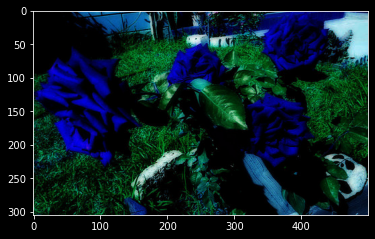

In [7]:
img_path = list(data_dir.glob('*/*.jpg'))
print(img_path)

sample = cv2.imread(os.path.join(img_path[0]))
plt.imshow(sample)

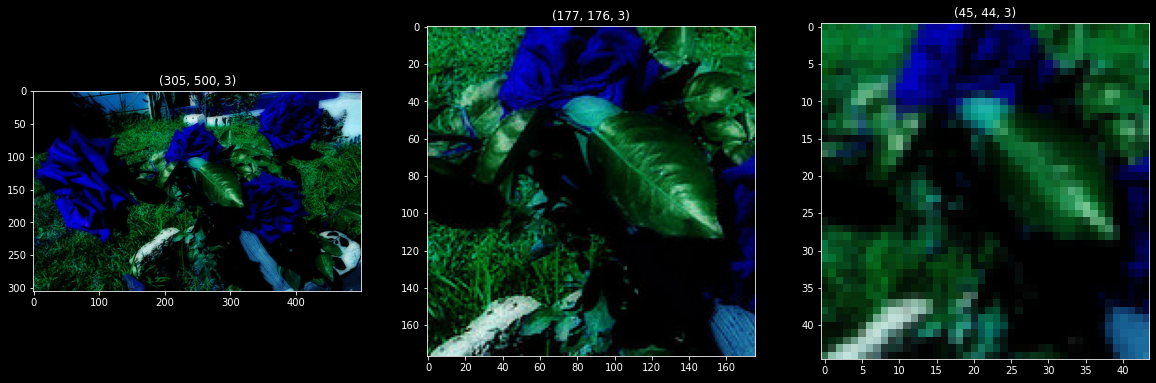

In [21]:
import matplotlib.pyplot as plt

h, w, _ = sample.shape
wnt_size = 176

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.title(sample.shape)
plt.imshow(sample)

## 정사각형으로 이미지 자르기
if h % 2 == 1:
  h = h - 1

crop_sample = sample[int((h-wnt_size)/2):int(-(h-wnt_size)/2), int((w-wnt_size)/2):int(-(w-wnt_size)/2), :]
plt.subplot(1, 3, 2)
plt.title(crop_sample.shape)
plt.imshow(crop_sample)

## 정사각형 이미지를 pyramid_reduce를 통해서 downscale한다.
from skimage.transform import pyramid_reduce
down_sample = pyramid_reduce(crop_sample, downscale=4, multichannel=True)
plt.subplot(1, 3, 3)
plt.title(down_sample.shape)
plt.imshow(down_sample)

In [22]:
print(((h-wnt_size)/2))
print((-(h-wnt_size)/2))
print((w-wnt_size)/2)
print(-(w-wnt_size)/2)

64.0
-64.0
162.0
-162.0


In [9]:
img_path = list(data_dir.glob('*/*.jpg'))

file_list = []
for i in range(image_count):
  file_list.append(os.path.join(img_path[i]))

total_cnt = len(file_list)
print('image_file 갯수:', total_cnt)

image_file 갯수: 3670


In [10]:
for idx, img in enumerate(file_list[:2]):
  load_img = cv2.imread(img)
  print(idx, img)

0 /root/.keras/datasets/flower_photos/roses/16018886851_c32746cb72.jpg
1 /root/.keras/datasets/flower_photos/roses/5172171681_5934378f08.jpg


In [11]:
training_cnt = int(total_cnt*0.8)
test_cnt = total_cnt - training_cnt
print(training_cnt, test_cnt)

2936 734


In [28]:
fn_makedirs(os.path.join(data_dir, 'train_lowres'))
fn_makedirs(os.path.join(data_dir, 'train_highres'))
fn_makedirs(os.path.join(data_dir, 'val_lowres'))
fn_makedirs(os.path.join(data_dir, 'val_highres'))
fn_makedirs(os.path.join(data_dir, 'test_lowres'))
fn_makedirs(os.path.join(data_dir, 'test_highres'))

print(fn_makedirs(os.path.join(data_dir, 'train_lowres')))

None


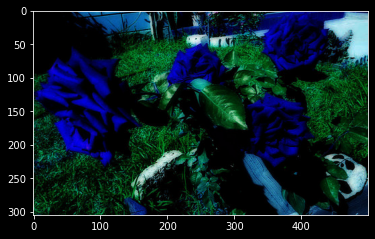

In [27]:
wnt_size = 176

for idx, img in enumerate(file_list[:1]):
  load_img = cv2.imread(img)
  plt.imshow(load_img)
  h, w, _ = load_img.shape
  crop = load_img[int((h-wnt_size)/2):int(-(h-wnt_size)/2), int((w-wnt_size)/2):int(-(w-wnt_size)/2), :]
    
  downsample_img = pyramid_reduce(crop, downscale=4, multichannel=True)
  
  norm = cv2.normalize(crop.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)

    ## training data
  if file_list[:1]:
      np.save(os.path.join(data_dir, 'train_lowres', str(idx) + '.npy'), downsample_img)
      np.save(os.path.join(data_dir, 'train_highres', str(idx) + '.npy'), norm)
  # elif int(label[1]) == 1:
  #     np.save(os.path.join(target_path, 'val_lowres', filename + '.npy'), down_img)
  #     np.save(os.path.join(target_path, 'val_lowres', filename + '.npy'), norm)
  # elif int(label[1]) == 2:
  #     np.save(os.path.join(target_path, 'val_lowres', filename + '.npy'), down_img)
  #     np.save(os.path.join(target_path, 'val_lowres', filename + '.npy'), norm)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
